# REI505M Machine Learning - Final project
### Due: --------

**Names**: Axel Kristján Axelsson, Bjarni Haukur Bjarnason <br />
**Email**: aka30@hi.is, bhb23@hi.is

**1. Image classification**

s


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
import tensorflow_io as tfio
tf.executing_eagerly()


from data_loader import MyDataLoader
from neural_nets import NeuralNets
from helper_funcs import *
from my_dataset import parse_to_image, parse_and_augment

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


%load_ext autoreload 
%autoreload 2

norm = (128,128)

dl = MyDataLoader("flowers", norm)
nn = NeuralNets(norm)

In [2]:
# dl.normalize_train_data()
# dl.all_to_one()
filenames = dl.get_all_filenames()

In [2]:
import math
from my_dataset import create_dataset_from_files

# filenames = dl.get_all_filenames()

# NUM_FILES = len(filenames)
# VAL_SIZE = 384
# TEST_SIZE = 64

# index_arr1 = np.random.choice(NUM_FILES, VAL_SIZE)
# index_arr2 = np.random.choice(NUM_FILES-VAL_SIZE, TEST_SIZE)

# val_files = filenames[index_arr1]
# train_files = np.delete(filenames, index_arr1)
# test_files = train_files[index_arr2]
# train_files = np.delete(train_files, index_arr2)
# NUM_FILES = len(filenames)

# numpy_dump(train_files, "small_train")
# numpy_dump(test_files, "small_test")
# numpy_dump(val_files, "small_val")

# train_files = numpy_load("train_files")
# test_files  = numpy_load("test_files")
# val_files   = numpy_load("val_files")

train_files = numpy_load("small_train")
test_files = numpy_load("small_test")
val_files = numpy_load("small_val")

BATCH_SIZE = 64
WORKERS    = 16
TEST_SIZE  = test_files.shape[0]
VAL_SIZE   = val_files.shape[0]
TRAIN_SIZE = train_files.shape[0]
NUM_FILES  = TEST_SIZE + VAL_SIZE + TRAIN_SIZE


NUM_TRAIN_STEPS = math.floor(TRAIN_SIZE/BATCH_SIZE)
NUM_VAL_STEPS   = math.floor(VAL_SIZE/BATCH_SIZE)

ds_train = create_dataset_from_files(train_files, batch_size=BATCH_SIZE, num_parallel_calls=WORKERS, augment=True)
ds_val   = create_dataset_from_files(val_files, batch_size=BATCH_SIZE, num_parallel_calls=WORKERS, augment=True)
ds_test  = create_dataset_from_files(test_files, batch_size=BATCH_SIZE, num_parallel_calls=WORKERS)

In [6]:
def SSIMLoss(y_true, y_pred):
  return (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0)))#+0.5*tf.keras.metrics.mean_squared_error(y_true,y_pred)

In [ ]:
model = nn.model_i()
model.compile(optimizer='rmsprop', loss=SSIMLoss, metrics=["accuracy"])
log_dir = "logs/fit/" + "model_i"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.summary()

In [ ]:
from random import randint


num_iters = 20

test_images = ds_test.as_numpy_iterator().next()


history_arr = np.ndarray(shape=(num_iters,), dtype=object)
for i in range(num_iters):
    history_arr[i] = model.fit(ds_train, epochs=5, steps_per_epoch=NUM_TRAIN_STEPS, validation_data=ds_val, validation_steps=NUM_VAL_STEPS, callbacks=[tensorboard_callback])
    
    if i%2==0:
        save_model(model, f"model_i_SSIMV2_{i}", brave=True)

    img_number = randint(0, BATCH_SIZE-1)
    img = np.expand_dims(test_images[0][img_number], 0)
    pred = model.predict(img)
    save_images(img , map_from(pred), name="model_i_SSIMV2", enumerate=i)

In [ ]:
from matplotlib import pyplot as plt
from helper_funcs import *

# new_arr = np.ndarray(shape=(30,), dtype=object)
# new_arr[:10] = history_arr
# new_arr[10:] = history_arr2

plot_acc_and_loss(history_arr, title="Model_i with 100% SSIM loss", name="model_i_SSIMV2", save=True, figsize=(10,10))


In [ ]:
# model = load_model("model_i_SSIM_10", custom={'SSIMLoss':SSIMLoss})
# model = gan.get_generator()
model.summary()

In [9]:
model = load_model("model_i_SSIMV219", custom={'SSIMLoss':SSIMLoss})
# model = gan.get_generator()

In [31]:
####################################################################################
# model_e14 frekar gott general skill, model_e40 gott en of miklir litir
####################################################################################
####################################################################################
# model_i_SSIM19 er skringilega gott
####################################################################################

# save_model(model, "model_e40")


# img_numbers = np.random.choice(size, 5)
# test_image = X_test[img_numbers]

test_image = ds_test.as_numpy_iterator().next()



num_images = 32

# grey = test_image[0][[14, 16, 18, 30,31,32,32,34,35,36,37,38,39]]
# ab   = test_image[1][[14, 16, 18, 30,31,32,32,34,35,36,37,38,39]]

grey = test_image[0][:num_images]
ab   = test_image[1][:num_images]
none_arr = np.zeros(shape=(num_images, norm[0], norm[1], 2))

pred = model.predict(grey)
# save_images(grey, none_arr, name="bw")
save_images(grey, map_from(pred), name="fake", enhance=1.2)
save_images(grey, map_from(ab), name="real")
# save_images(grey, map_from(ab), name="rgb")
# show_images(grey, map_from(ab))
# show_images(grey, map_from(pred), enhance=1.2)
# show_images(grey, map_from(ab))


In [ ]:
from random import randint

iter = ds_test.as_numpy_iterator()
test_image = iter.next()

num_images = 10

grey = test_image[0][:num_images]
ab   = test_image[1][:num_images]
pred = model.predict(grey)
for i in range(num_images):
    rand = randint(0, 1)
    if rand:
        show_images(grey[i:i+1], map_from(ab[i:i+1]), enhance=0.8)
    else:
        show_images(grey[i:i+1], map_from(pred[i:i+1]), enhance=1.2)
    print(rand)

In [3]:
from gan import MyGAN
gan = MyGAN(ds_train, ds_val, nn.generator_b(), nn.discriminator_a())
# try:
#     trained = gan.is_trained()
#     if not trained:
#         gan = MyGAN(ds_train, ds_val, nn.generator_b(), nn.discriminator_b())
# except:
#     pass

In [4]:
from random import randint


num_iters = 10

test_images = ds_test.as_numpy_iterator().next()

# gan.train_individually(2, 12, NUM_TRAIN_STEPS, NUM_VAL_STEPS)

for i in range(num_iters):
    gan.fit(num_epochs=5, num_train_steps=NUM_TRAIN_STEPS, num_val_steps=NUM_VAL_STEPS)
    
    model = gan.get_generator()

    img_number = randint(0, BATCH_SIZE-1)
    img = np.expand_dims(test_images[0][img_number], 0)
    pred = model(img)
    save_images(img , map_from(pred), name="gan", enumerate=i)

Validating...
___________________________ Epoch 1 ______________________
Generator loss:         0.689
Generator val loss:     0.693
Discriminator loss:     1.387
Discriminator val loss: 1.386
Validating...
___________________________ Epoch 2 ______________________
Generator loss:         0.693
Generator val loss:     0.693
Discriminator loss:     1.386
Discriminator val loss: 1.386


4
4
[]


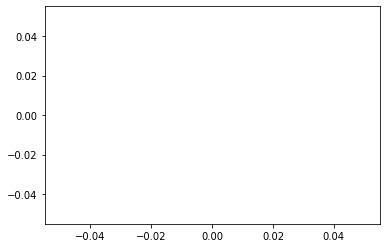

In [48]:
print(len(train))
print(len(val))
print(val[0])
plt.plot(val[0])